## Data Science with GitHub Codespaces and Azure: Logistic Regression
_Adapted from [Machine Learning for Beginners](https://github.com/microsoft/ML-For-Beginners/blob/main/2-Regression/4-Logistic/README.md)_


In [1]:
import pandas as pd
import numpy as np

full_pumpkins = pd.read_csv('data/US-pumpkins.csv')

full_pumpkins.head()

City Name Type       Package      Variety Sub Variety  Grade     Date  \
0  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN  4/29/17   
1  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN   5/6/17   
2  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
3  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
4  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  11/5/16   

   Low Price  High Price  Mostly Low  ...  Unit of Sale Quality Condition  \
0      270.0       280.0       270.0  ...           NaN     NaN       NaN   
1      270.0       280.0       270.0  ...           NaN     NaN       NaN   
2      160.0       160.0       160.0  ...           NaN     NaN       NaN   
3      160.0       160.0       160.0  ...           NaN     NaN       NaN   
4       90.0       100.0        90.0  ...           NaN     NaN       NaN   

  Appearance Storage  Crop Repack  Trans Mode  Unnamed: 24  Unnamed: 25  
0        NaN     NaN   NaN      E         NaN          NaN          NaN  
1        NaN     NaN   NaN      E         NaN          NaN          NaN  
2        NaN     NaN   NaN      N         NaN          NaN          NaN  
3        NaN     NaN   NaN      N         NaN          NaN          NaN  
4        NaN     NaN   NaN      N         NaN          NaN          NaN  

[5 rows x 26 columns]

In [2]:
# Select the columns we want to use
columns_to_select = ['City Name','Package','Variety', 'Origin','Item Size', 'Color']
pumpkins = full_pumpkins.loc[:, columns_to_select]

# Drop rows with missing values
pumpkins.dropna(inplace=True)

# Export to file
pumpkins.to_csv('data/US-pumpkins-clean.csv')

pumpkins.head()

City Name       Package      Variety    Origin Item Size   Color
2  BALTIMORE  24 inch bins  HOWDEN TYPE  DELAWARE       med  ORANGE
3  BALTIMORE  24 inch bins  HOWDEN TYPE  VIRGINIA       med  ORANGE
4  BALTIMORE  24 inch bins  HOWDEN TYPE  MARYLAND       lge  ORANGE
5  BALTIMORE  24 inch bins  HOWDEN TYPE  MARYLAND       lge  ORANGE
6  BALTIMORE  36 inch bins  HOWDEN TYPE  MARYLAND       med  ORANGE

# Uploading data to Azure
We've now cleaned our data, let's upload it to the cloud with the Azure Cli. We'll use a script to upload the `US-pumpkins-clean.csv` with the cli. 

The [script](create-blob.sh) will:
- Create a resource group named `codespace-workshop-rg-#####`
- Create a storage account named `csblobstg#####`
- Create a blob container named `data` (_note: containers in this context are like "folders"_ )
- Upload the `US-pumpkins-clean.csv` file to the data container

It will output the name of your storage 

1. In the terminal (make sure you're in your virtual environment) run the following:
`az login --use-device-code`

2. Follow the authentication instructions

3. Return to the terminal and run: 
`chmod +x ./data-science-codespaces/create-blob.sh`

4. Run the follwing script:
`./data-science-codespaces/create-blob.sh`

5. If prompted to install the storage-preview cli extension, select `yes`

6. From the terminal, get the STORAGEACCOUNTURL and STORAGEACCOUNTKEY output values and set them in your codespaces secrets by going to your repo `settings > secrets and variables > codespaces > new repository secret`

![Codespace secrets](../images/codespace-secret.png)

7. Your codespace will reload with these secrets as environment variables.


In [5]:
from azure.storage.blob import BlobServiceClient
import os

STORAGEACCOUNTURL= os.environ['STORAGEACCOUNTURL']
STORAGEACCOUNTKEY= os.environ['STORAGEACCOUNTKEY']
LOCALFILENAME= "US-pumpkins-clean.csv"
CONTAINERNAME= "data"
BLOBNAME= "US-pumpkins-clean.csv"

#download from blob
blob_service_client_instance = BlobServiceClient(account_url=STORAGEACCOUNTURL, credential=STORAGEACCOUNTKEY)
blob_client_instance = blob_service_client_instance.get_blob_client(CONTAINERNAME, BLOBNAME, snapshot=None)
with open(LOCALFILENAME, "wb") as my_blob:
    blob_data = blob_client_instance.download_blob()
    blob_data.readinto(my_blob)

pumpkins = pd.read_csv(LOCALFILENAME)


# Let's have a look to our data!

By visualising it with Seaborn

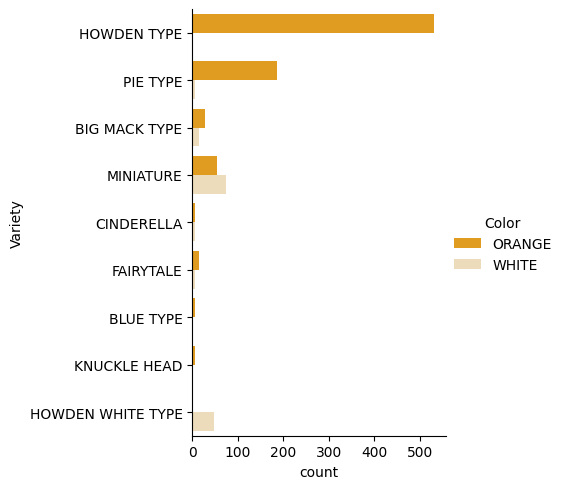

In [7]:
import seaborn as sns
# Specify colors for each values of the hue variable
palette = {
    'ORANGE': 'orange',
    'WHITE': 'wheat',
}
# Plot a bar plot to visualize how many pumpkins of each variety are orange or white
sns.catplot(
    data=pumpkins, y="Variety", hue="Color", kind="count",
    palette=palette, 
)

# Data pre-processing

Let's encode features and labels to better plot the data and train the model

In [8]:
# Let's look at the different values of the 'Item Size' column
pumpkins['Item Size'].unique()

array(['med', 'lge', 'sml', 'xlge', 'med-lge', 'jbo', 'exjbo'],
      dtype=object)

In [9]:
from sklearn.preprocessing import OrdinalEncoder
# Encode the 'Item Size' column using ordinal encoding
item_size_categories = [['sml', 'med', 'med-lge', 'lge', 'xlge', 'jbo', 'exjbo']]
ordinal_features = ['Item Size']
ordinal_encoder = OrdinalEncoder(categories=item_size_categories)

In [10]:
from sklearn.preprocessing import OneHotEncoder
# Encode all the other features using one-hot encoding
categorical_features = ['City Name', 'Package', 'Variety', 'Origin']
categorical_encoder = OneHotEncoder(sparse_output=False)

In [11]:
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(transformers=[
     ('ord', ordinal_encoder, ordinal_features),
     ('cat', categorical_encoder, categorical_features)
     ])
# Get the encoded features as a pandas DataFrame
ct.set_output(transform='pandas')
encoded_features = ct.fit_transform(pumpkins)
encoded_features.head()

ord__Item Size  cat__City Name_ATLANTA  cat__City Name_BALTIMORE  \
0             1.0                     0.0                       1.0   
1             1.0                     0.0                       1.0   
2             3.0                     0.0                       1.0   
3             3.0                     0.0                       1.0   
4             1.0                     0.0                       1.0   

   cat__City Name_BOSTON  cat__City Name_CHICAGO  cat__City Name_COLUMBIA  \
0                    0.0                     0.0                      0.0   
1                    0.0                     0.0                      0.0   
2                    0.0                     0.0                      0.0   
3                    0.0                     0.0                      0.0   
4                    0.0                     0.0                      0.0   

   cat__City Name_DALLAS  cat__City Name_DETROIT  cat__City Name_LOS ANGELES  \
0                    0.0                     0.0                         0.0   
1                    0.0                     0.0                         0.0   
2                    0.0                     0.0                         0.0   
3                    0.0                     0.0                         0.0   
4                    0.0                     0.0                         0.0   

   cat__City Name_MIAMI  ...  cat__Origin_MICHIGAN  cat__Origin_NEW JERSEY  \
0                   0.0  ...                   0.0                     0.0   
1                   0.0  ...                   0.0                     0.0   
2                   0.0  ...                   0.0                     0.0   
3                   0.0  ...                   0.0                     0.0   
4                   0.0  ...                   0.0                     0.0   

   cat__Origin_NEW YORK  cat__Origin_NORTH CAROLINA  cat__Origin_OHIO  \
0                   0.0                         0.0               0.0   
1                   0.0                         0.0               0.0   
2                   0.0                         0.0               0.0   
3                   0.0                         0.0               0.0   
4                   0.0                         0.0               0.0   

   cat__Origin_PENNSYLVANIA  cat__Origin_TENNESSEE  cat__Origin_TEXAS  \
0                       0.0                    0.0                0.0   
1                       0.0                    0.0                0.0   
2                       0.0                    0.0                0.0   
3                       0.0                    0.0                0.0   
4                       0.0                    0.0                0.0   

   cat__Origin_VERMONT  cat__Origin_VIRGINIA  
0                  0.0                   0.0  
1                  0.0                   1.0  
2                  0.0                   0.0  
3                  0.0                   0.0  
4                  0.0                   0.0  

[5 rows x 48 columns]

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Encode the 'Color' column using label encoding
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(pumpkins['Color'])
encoded_pumpkins = encoded_features.assign(Color=encoded_label)
encoded_pumpkins.head()

In [ ]:
# Let's look at the mapping between the encoded values and the original values
list(label_encoder.inverse_transform([0, 1]))

# Analysing relationships between features and label

In [ ]:
palette = {
    'ORANGE': 'orange',
    'WHITE': 'wheat',
}
# We need the encoded Item Size column to use it as the x-axis values in the plot
pumpkins['Item Size'] = encoded_pumpkins['ord__Item Size']

g = sns.catplot(
    data=pumpkins,
    x="Item Size", y="Color", row='Variety',
    kind="box", orient="h",
    sharex=False, margin_titles=True,
    height=1.5, aspect=4, palette=palette,
)
# Defining axis labels 
g.set(xlabel="Item Size", ylabel="").set(xlim=(0,6))
g.set_titles(row_template="{row_name}")


Let's now focus on a specific relationship: Item Size and Color!

In [ ]:
palette = {
    '0': 'orange',
    '1': 'wheat'
}
sns.swarmplot(x="Color", y="ord__Item Size", data=encoded_pumpkins, palette=palette)

# Build your model

In [ ]:
from sklearn.model_selection import train_test_split
# X is the encoded features
X = encoded_pumpkins[encoded_pumpkins.columns.difference(['Color'])]
# y is the encoded label
y = encoded_pumpkins['Color']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report 
from sklearn.linear_model import LogisticRegression

# Train a logistic regression model on the pumpkin dataset
model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate the model and print the results
print(classification_report(y_test, predictions))
print('Predicted labels: ', predictions)
print('F1-score: ', f1_score(y_test, predictions))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

y_scores = model.predict_proba(X_test)
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
# Calculate AUC score
auc = roc_auc_score(y_test,y_scores[:,1])
print(auc)